In [1]:
from transformers import AutoAdapterModel, AdapterConfig

In [3]:
from datasets import load_dataset

In [54]:
d = load_dataset("glue", "qqp")

Downloading:   0%|          | 0.00/41.7M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset glue downloaded and prepared to /home/jjukic/.cache/huggingface/datasets/glue/qqp/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [56]:
d

DatasetDict({
    train: Dataset({
        features: ['question1', 'question2', 'label', 'idx'],
        num_rows: 363846
    })
    validation: Dataset({
        features: ['question1', 'question2', 'label', 'idx'],
        num_rows: 40430
    })
    test: Dataset({
        features: ['question1', 'question2', 'label', 'idx'],
        num_rows: 390965
    })
})

In [57]:
def save_dataset(hfd, name):
    hfd["train"].to_pandas()[['question1', 'question2', 'label']].sample(5_000).reset_index(drop=True).to_csv(f"data/{name}/train.csv", header=False)
    hfd["test"].to_pandas()[['question1', 'question2', 'label']].sample(2_000).reset_index(drop=True).to_csv(f"data/{name}/test.csv", header=False)
    hfd["validation"].to_pandas()[['question1', 'question2', 'label']].sample(1_000).reset_index(drop=True).to_csv(f"data/{name}/validation.csv", header=False)
    
save_dataset(d, "QQP")

In [2]:
model = AutoAdapterModel.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertAdapterModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertAdapterModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertAdapterModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
a = model.load_adapter("adapters/TREC-2-BERT-pfeiffer")

Overwriting existing adapter 'TREC-2-BERT-pfeiffer'.
Overwriting existing head 'TREC-2-BERT-pfeiffer'


In [7]:
model.add_classification_head("head", num_labels=2)

In [8]:
model.add_adapter("head")
model.train_adapter("head")

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy

from dataloaders import *
from util import Config
from viz_utils import *


In [14]:
datasets = ["MRPC", "TREC-2", "SUBJ", "AGN-2", "TREC-6", "AGN-4", "SST"]
dataset_map = {"TREC-2": "TREC-2", "SUBJ": "SUBJ", "AGN-2": "AGN-2", "TREC-6": "TREC-full", "SST": "SST", "COLA": "COLA", "AGN-4": "ag_news-full"}
models = ["BERT", "ELECTRA"]
load_anti = False
n = 0 # AL step at which evaluation (AUC) starts
model = "BERT"
mode = "ada"
dataset = "TREC-2"

aucs = []
trs = []
try:
    experiments, meta = load_results(
        base_dir=f"results/parallel",
        dataset=dataset,
        model=model,
    )
except:
    print(f"No experiments for {dataset}-{model}-{mode}")
for load_mode in ["last", "best"]:
    if mode == "short" and load_mode == "best":
        continue
    mode_print = mode if load_mode == "last" else f"{mode}-besov"
    print(f"Loading {dataset} -- {mode_print} -- {model}")
    df_tr_i = results_to_df(experiments, mode=load_mode)

    df_tr_i["model"] = model
    df_tr_i["mode"] = mode_print
    df_tr_i["dataset"] = dataset
    df_tr_i = df_tr_i.reset_index().set_index(["dataset", "model", "mode", "sampler", "experiment", "al_iter"])
    trs.append(df_tr_i)
        
    df_auc_i = al_auc(df_tr_i)
    df_auc_i["mode"] = mode_print
    df_auc_i = df_auc_i.reset_index().set_index(["mode", "sampler"])
    aucs.append(df_auc_i)
                
        


# plot_besov_index(df_tr, ci=0)
# plot_al_accuracy(df_tr, metric="f1_micro", ci=0)
df_tr = pd.concat(trs)
df_auc = pd.concat(aucs)

TREC-2-BERT
Loading TREC-2 -- ada -- BERT
Loading TREC-2 -- ada-besov -- BERT


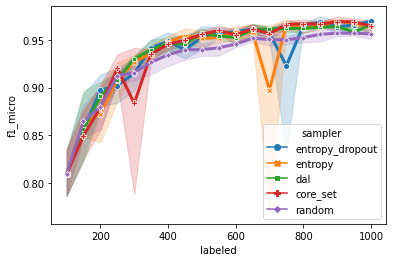

In [15]:
g = sns.lineplot(
data=df_tr[df_tr.index.get_level_values("mode") == "ada-besov"],
    x="labeled",
    y="f1_micro",
    hue="sampler",
    style="sampler",
    markers=True,
    dashes=False,
    ci=95,
    linewidth=3,
)
# g.set_ylim(0.92, 0.96)
# g.set_xlim(100, 1000)

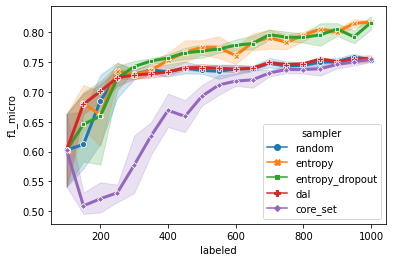

In [43]:
g = sns.lineplot(
data=df_tr[df_tr.index.get_level_values("mode") == "ada-besov"],
    x="labeled",
    y="f1_micro",
    hue="sampler",
    style="sampler",
    markers=True,
    dashes=False,
    ci=95,
    linewidth=3,
)
# g.set_ylim(0.82, 0.92)
# g.set_xlim(500, 1000)